In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
#import requests # API library

import random
import time
import os

#from isoweek import Week

#import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



/tmp/ipykernel_2327/3051370682.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Expects an observation from df
def model2(obs):
    hyper_sigma = 1/8
    #
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

# Training on fake data where coach 1 always wins.

In [7]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoDiagonalNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = torch.ones(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 681.3502424955368
Step 100 : loss = 37.33546966314316
Step 200 : loss = 0.47864317893981934
Step 300 : loss = -28.37623643875122
Step 400 : loss = -35.6906658411026
Step 500 : loss = -28.36746311187744
Step 600 : loss = -41.47890090942383
Step 700 : loss = -28.350199699401855
Step 800 : loss = -27.262890815734863
Step 900 : loss = -27.793318271636963
Step 1000 : loss = -28.014233350753784
Step 1100 : loss = -36.97495996952057
Step 1200 : loss = -31.910523891448975
Step 1300 : loss = -34.68488085269928
Step 1400 : loss = -19.79091203212738
Step 1500 : loss = -30.988765478134155
Step 1600 : loss = -22.079681396484375
Step 1700 : loss = -30.955865502357483
Step 1800 : loss = -33.65371024608612
Step 1900 : loss = -42.06246793270111
Step 2000 : loss = -31.384063601493835
Step 2100 : loss = -29.75011694431305
Step 2200 : loss = -29.33793342113495
Step 2300 : loss = -25.846678972244263
Step 2400 : loss = -32.50102078914642
Step 2500 : loss = -30.14213275909424
Step 2600 : loss

In [8]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)


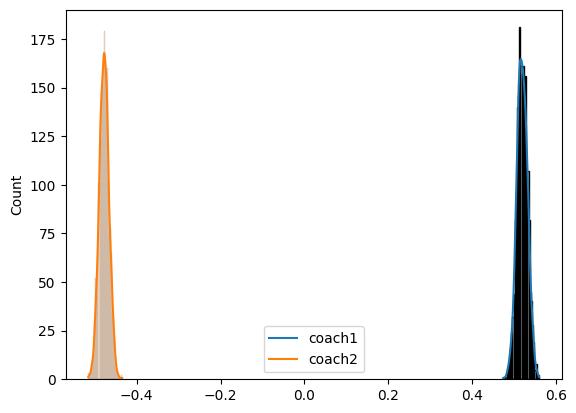

In [9]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where each match is a draw.

In [10]:
# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoDiagonalNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = torch.zeros(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 793.3858596682549
Step 100 : loss = 41.88117069005966
Step 200 : loss = -14.979873657226562
Step 300 : loss = -27.428137183189392
Step 400 : loss = -32.11896616220474
Step 500 : loss = -19.002576410770416
Step 600 : loss = -3.6199201941490173
Step 700 : loss = -24.584280133247375
Step 800 : loss = -29.592718839645386
Step 900 : loss = -37.17561620473862
Step 1000 : loss = -31.94342476129532
Step 1100 : loss = -29.155588448047638
Step 1200 : loss = -42.02727884054184
Step 1300 : loss = -33.5853705406189
Step 1400 : loss = -31.820321679115295
Step 1500 : loss = -38.25704050064087
Step 1600 : loss = -28.67832887172699
Step 1700 : loss = -42.67898488044739
Step 1800 : loss = -34.91869121789932
Step 1900 : loss = -30.76371330022812
Step 2000 : loss = -25.042203783988953
Step 2100 : loss = -34.651028513908386
Step 2200 : loss = -15.605410695075989
Step 2300 : loss = -27.449113607406616
Step 2400 : loss = -28.32122927904129
Step 2500 : loss = -31.65087580680847
Step 2600 : los

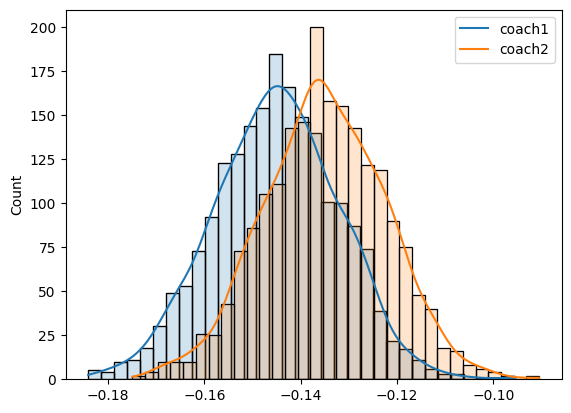

In [11]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where coach 2 always wins.

In [12]:
# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoDiagonalNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100
#This is fake data, just show that the model can be trained
obs = -torch.ones(num_games)
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 2132.081843793392
Step 100 : loss = -19.337827801704407
Step 200 : loss = 18.04259729385376
Step 300 : loss = -15.383113026618958
Step 400 : loss = -20.885378003120422
Step 500 : loss = -34.547396659851074
Step 600 : loss = -29.195896565914154
Step 700 : loss = -36.904413640499115
Step 800 : loss = -35.597957491874695
Step 900 : loss = -34.365458369255066
Step 1000 : loss = -38.74925982952118
Step 1100 : loss = -27.322131037712097
Step 1200 : loss = -34.58989804983139
Step 1300 : loss = -36.33470559120178
Step 1400 : loss = -24.233390510082245
Step 1500 : loss = -40.47123622894287
Step 1600 : loss = -22.831524074077606
Step 1700 : loss = -44.681172013282776
Step 1800 : loss = -34.056329011917114
Step 1900 : loss = -24.30671662092209
Step 2000 : loss = -32.08572566509247
Step 2100 : loss = -28.080514132976532
Step 2200 : loss = -41.294204890728
Step 2300 : loss = -39.760772824287415
Step 2400 : loss = -42.835461020469666
Step 2500 : loss = -27.972557842731476
Step 2600 :

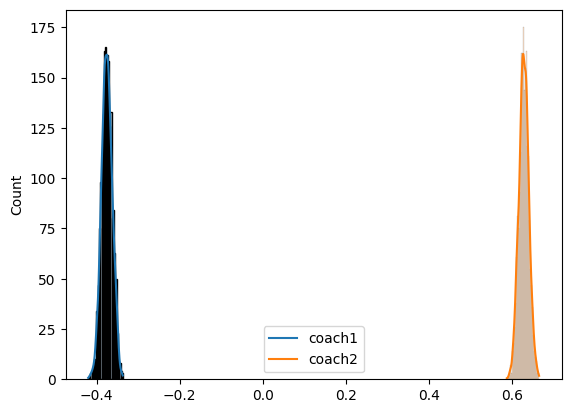

In [13]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Comparing distributions from fake data based on number of games played.

In [23]:
from pyro.infer import Predictive

# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})

coach1_skill_inf = np.empty((3, 2000))
coach2_skill_inf = np.empty((3, 2000))

for i in range(2,5):
    pyro.clear_param_store()

    # Training loop
    num_steps = 5000
    num_games = 10**i

    guide = AutoDiagonalNormal(model2)
    svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

    print(f"Training for {num_games} games")
    #This is fake data, just show that the model can be trained
    obs = torch.ones(num_games)
    for step in range(num_steps):    
        #Feed in batches (e.g. batches of observations)
        loss = svi.step(obs)
        """if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")"""


    #This is an example of inference after training
    predictive = Predictive(model2, guide=guide, num_samples=2000,
                            return_sites=("coach1_skill", "coach2_skill"))

    samples = predictive(obs)

    coach1_skill_inf[i-2] = samples["coach1_skill"].detach().squeeze()
    coach2_skill_inf[i-2] = samples["coach2_skill"].detach().squeeze()



Training for 100 games
Training for 1000 games
Training for 10000 games


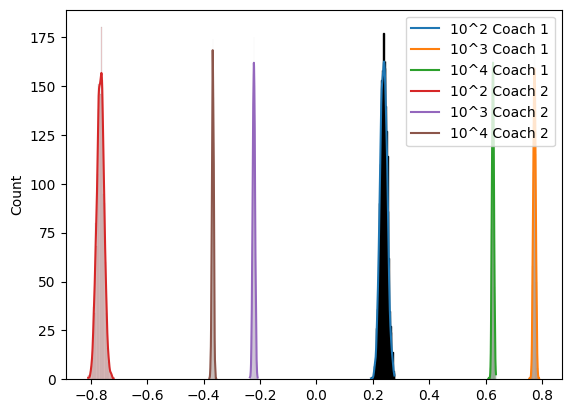

In [24]:
import seaborn as sns

#Plotting the data
sns.histplot(coach1_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach1_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach1_skill_inf[2], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[2], kde=True, alpha=0.2)
plt.legend(["10^2 Coach 1", "10^3 Coach 1", "10^4 Coach 1","10^2 Coach 2", "10^3 Coach 2", "10^4 Coach 2"])
plt.show()

# Lets try and make some fake data where coach 1 starts by losing but slowly gets better.

In [27]:
obs1 = -torch.ones(100)
obs2 = torch.zeros(100)
obs3 = torch.ones(200)

obs = torch.cat((obs1, obs2, obs3))

# clear param store
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoDiagonalNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
#This is fake data, just show that the model can be trained
for step in range(num_steps):    
    #Feed in batches (e.g. batches of observations)
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 9237.900853276253
Step 100 : loss = 2940.887066721916
Step 200 : loss = 2785.40215998888
Step 300 : loss = 2773.349117219448
Step 400 : loss = 2821.256288230419
Step 500 : loss = 2774.3377982378006
Step 600 : loss = 2832.9163747429848
Step 700 : loss = 2799.3964022397995
Step 800 : loss = 2790.5372171998024
Step 900 : loss = 2805.422292292118
Step 1000 : loss = 2792.8180015087128
Step 1100 : loss = 2786.4806522727013
Step 1200 : loss = 2767.841854929924
Step 1300 : loss = 2786.6383824944496
Step 1400 : loss = 2792.1175420880318
Step 1500 : loss = 2783.6999401450157
Step 1600 : loss = 2771.5774078965187
Step 1700 : loss = 2786.1581089496613
Step 1800 : loss = 2765.1498661637306
Step 1900 : loss = 2807.557376384735
Step 2000 : loss = 2774.4528760910034
Step 2100 : loss = 2796.231511950493
Step 2200 : loss = 2770.614674091339
Step 2300 : loss = 2802.2492017149925
Step 2400 : loss = 2799.2017539143562
Step 2500 : loss = 2796.72306650877
Step 2600 : loss = 2792.7490797042847

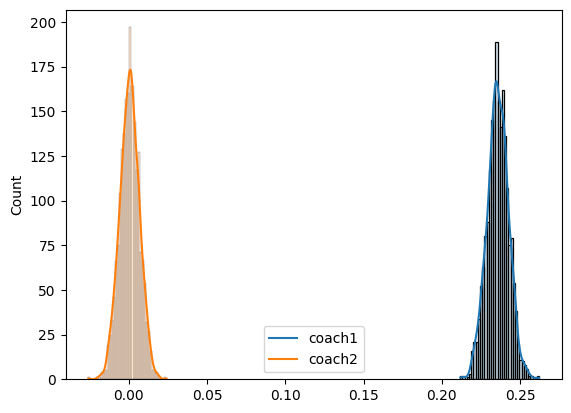

In [28]:
from pyro.infer import Predictive

#This is an example of inference after training
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()